# Assignment 1 - Linear Regression

Class: COMP 5630 - Machine Learning

Author: Chris Hinkson

Email: cmh0201@auburn.edu



### Table of Contents

1) [Project Imports and Configuration](#project-imports-and-configuration)

## Project Imports and Configuration

Some module imports and configurations are needed for this project. The below code cell loads all of the needed modules for both tasks in this assignment. While the individual task reports may identify how specific modules are used, a general description of the modules is as follows:

- [Python's OS Module](https://docs.python.org/3/library/os.html) allows for interacting with various system interfaces, primarily files in this project.
- [Requests](https://pypi.org/project/requests/) provides HTTP support for downloading resources.
- [Itertools](https://docs.python.org/3/library/itertools.html) provides easy iteration over list subsets.
- [Pandas](https://pandas.pydata.org/) allows for efficient data storage.
- [Numpy](https://numpy.org/) allows for efficient data storage.
- [MatPlotLib](https://matplotlib.org/) provides plotting to display results.
- [Tabulate](https://pypi.org/project/tabulate/) makes displaying results much cleaner.
- [TQDM](https://tqdm.github.io/) makes displaying iteration progress much easier via progress bars.

In [64]:
# Sklearn
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Data
import numpy as np
import pandas as pd

# Display
import tabulate
from tqdm import tqdm
import matplotlib.pyplot as plt

## Part 1: Dataset and Preprocessing

This section will load the dataset and preprocess it as described in the assignment instructions.

### Load Wine Dataset

This code block will load the wine dataset from sklearn then split it into training and test sets.

In [41]:
# Load the wine dataset into features and labels
df_Features, df_Target = load_wine(return_X_y=True, as_frame=True)

# Split the dataset into training and testing sets
train_Features, test_Features, train_Target, test_Target = train_test_split(df_Features, df_Target, 
																			test_size=0.20, 
																			stratify=df_Target, 
																			random_state=15)

### Standardization

This code block will use the StandardScaler to standardize our dataset.

In [42]:
# Create scaler with sklearn
scaler = StandardScaler()

# Fit and transform training features/target
train_Features_scaled = scaler.fit_transform(X=train_Features)

# Only transform for the test features/target
test_Features_scaled = scaler.transform(X=test_Features)

### Class Splitting

This code block will split the target set into classes (one hot encoding).

In [43]:
# Create onehot encoder with sklearn
onehotencoder = OneHotEncoder(sparse_output=False)

# Fit and transform training target
train_Target_reshaped = train_Target.values.reshape(-1, 1)
train_Target_encoded = onehotencoder.fit_transform(train_Target_reshaped)
train_Target_encoded = pd.DataFrame(
    data=train_Target_encoded,
    columns=[f"class_{category}" for category in onehotencoder.categories_[0]],
)

# Only transform for the test target
test_Target_reshaped = test_Target.values.reshape(-1, 1)
test_Target_encoded = onehotencoder.transform(test_Target_reshaped)
test_Target_encoded = pd.DataFrame(
    data=test_Target_encoded,
    columns=[f"class_{category}" for category in onehotencoder.categories_[0]],
)

### Dataset Investigation

This code block will identify the shapes of the training set and the distribution of the target.

Dataset Preprocessing Completed!
Training Features Shape: (142, 13)
Training Target Shape: (142, 3)


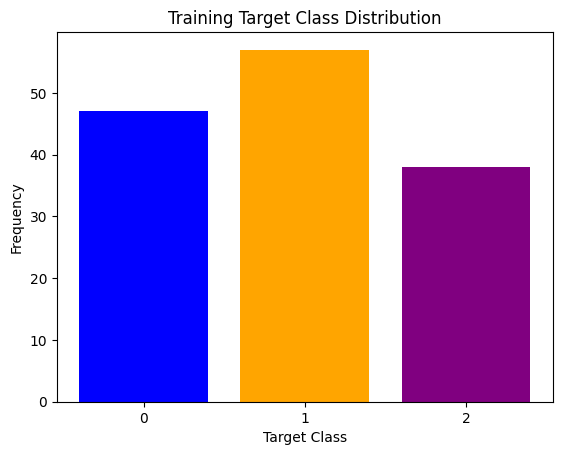

In [44]:
# Print the shapes of the training features and target
print(f"Dataset Preprocessing Completed!")
print(f"Training Features Shape: {train_Features_scaled.shape}")
print(f"Training Target Shape: {train_Target_encoded.shape}")

# Make bar plot of target distribution
train_Target_distribution = train_Target.value_counts().sort_index()
barColors = ['blue', 'orange', 'purple']
plt.bar(train_Target_distribution.index, train_Target_distribution.values, color=barColors)
plt.xticks(ticks=[0, 1, 2], labels=[0, 1, 2])
plt.xlabel("Target Class")
plt.ylabel("Frequency")
plt.title("Training Target Class Distribution")
plt.show()

## Part 2: Logistic Regression with Gradient Descent

This section will implement logistic regression with gradient descent from scratch.

### Logistic Regression Model

This code block will create a logistic regression model class for use in each of the three class prediction models.

In [45]:
class LogisticRegressionFromScratch:

	def __init__(self, learningRate: float=0.0001, numIterations: int=10000, numFeatures: int=13, modelIdentifier="LogisticRegressionModel"):
		'''
		## Logistic Regression Model Initialization
		'''

		# Save input parameters
		self.learningRate = learningRate
		self.numIterations = numIterations
		self.numFeatures = numFeatures
		self.modelIdentifier = modelIdentifier

		# Initialize the weights and bias based on the number of features
		self.weights = np.zeros(numFeatures)
		self.bias = 0.0

		# Initialize an array for holding the losses and accuracies at each iteration
		self.trainingLosses = np.empty(numIterations)
		self.trainingAccuracies = np.empty(numIterations)

	def _sigmoid(self, z: np.ndarray) -> np.ndarray:
		'''
		## Sigmoid Activation Function
		'''
		return 1 / (1 + np.exp(-z))
	
	def _logLikelihoodLoss(self, predictions: np.ndarray, actuals: np.ndarray) -> float:
		'''
		## Log Likelihood Loss Function
		'''
		return np.sum((actuals * np.log(predictions)) + ((1 - actuals) * np.log(1 - predictions)))
	
	def _logLikelihoodLossGradient(self, features: np.ndarray, predictions: np.ndarray, actuals: np.ndarray) -> tuple[np.ndarray, float]:
		'''
		## Log Likelihood Loss Gradient
		'''
		weightGradient = np.dot(features.T, predictions - actuals) / len(features)
		biasGradient = np.mean(predictions - actuals)
		return weightGradient, biasGradient
	
	def computeAccuracy(self, predictions: np.ndarray, actuals: np.ndarray) -> float:
		'''
		## Accuracy
		'''
		return np.sum(predictions == actuals) / len(actuals)

	def predict(self, features: np.ndarray) -> np.ndarray:
		'''
		## Predictions
		'''
		return self._sigmoid(np.dot(features, self.weights) + self.bias)

	def classifyPredictions(self, predictions: np.ndarray, threshold: float=0.5) -> np.ndarray:
		'''
		## Classify Predictions
		'''
		return (predictions >= threshold).astype(int)

	def train(self, features: np.ndarray, actuals: np.ndarray):
		'''
		## Training with Gradient Descent
		'''

		# Verify that the size of features and size of weights match
		if features.shape[1] != self.weights.shape[0]:
			raise ValueError(f"Error when training model {self.modelIdentifier}: Number of features does not match number of weights.")
		
		# Perform gradient descent for the specified number of iterations
		for iteration in tqdm(range(self.numIterations), desc=f"Model {self.modelIdentifier} Training Progress", unit="iteration"):

			# Calculate predictions
			predictions = self.predict(features)

			# Calculate loss, accuracy, and gradients
			self.trainingLosses[iteration] = self._logLikelihoodLoss(predictions, actuals)
			self.trainingAccuracies[iteration] = self.computeAccuracy(self.classifyPredictions(predictions), actuals)
			weightGradient, biasGradient = self._logLikelihoodLossGradient(features, predictions, actuals)

			# Update weights and bias
			self.weights -= self.learningRate * weightGradient
			self.bias -= self.learningRate * biasGradient

### Class Model Creations

This code block will create models for each of the classes.

In [65]:
# Create logistic regression models for each class
scratch_logisticRegressionModel_class0 = LogisticRegressionFromScratch(learningRate=0.01, numIterations=10000, numFeatures=train_Features_scaled.shape[1], modelIdentifier="LRM_Class0")
scratch_logisticRegressionModel_class1 = LogisticRegressionFromScratch(learningRate=0.01, numIterations=10000, numFeatures=train_Features_scaled.shape[1], modelIdentifier="LRM_Class1")
scratch_logisticRegressionModel_class2 = LogisticRegressionFromScratch(learningRate=0.01, numIterations=10000, numFeatures=train_Features_scaled.shape[1], modelIdentifier="LRM_Class2")

### Model Training

This code block will train each of the models with their respective classes.

In [66]:
# Train each of the models
scratch_logisticRegressionModel_class0.train(features=train_Features_scaled.copy(), actuals=train_Target_encoded["class_0"].values.copy())
scratch_logisticRegressionModel_class1.train(features=train_Features_scaled.copy(), actuals=train_Target_encoded["class_1"].values.copy())
scratch_logisticRegressionModel_class2.train(features=train_Features_scaled.copy(), actuals=train_Target_encoded["class_2"].values.copy())

# Get the final training accuracies for each model
scratch_accuracy_finalTraining_class0 = scratch_logisticRegressionModel_class0.trainingAccuracies[-1]
scratch_accuracy_finalTraining_class1 = scratch_logisticRegressionModel_class1.trainingAccuracies[-1]
scratch_accuracy_finalTraining_class2 = scratch_logisticRegressionModel_class2.trainingAccuracies[-1]

Model LRM_Class2 Training Progress: 100%|██████████| 10000/10000 [00:00<00:00, 56211.33iteration/s]


### Model Testing

This code block will test each of the models.

In [67]:
# Make predictions for each model
scratch_predictions_class0 = scratch_logisticRegressionModel_class0.predict(test_Features_scaled)
scratch_predictions_class1 = scratch_logisticRegressionModel_class1.predict(test_Features_scaled)
scratch_predictions_class2 = scratch_logisticRegressionModel_class2.predict(test_Features_scaled)

# Compute test accuracies for each model
scratch_accuracy_test_class0 = scratch_logisticRegressionModel_class0.computeAccuracy(scratch_logisticRegressionModel_class0.classifyPredictions(scratch_predictions_class0), test_Target_encoded["class_0"].values)
scratch_accuracy_test_class1 = scratch_logisticRegressionModel_class1.computeAccuracy(scratch_logisticRegressionModel_class1.classifyPredictions(scratch_predictions_class1), test_Target_encoded["class_1"].values)
scratch_accuracy_test_class2 = scratch_logisticRegressionModel_class2.computeAccuracy(scratch_logisticRegressionModel_class2.classifyPredictions(scratch_predictions_class2), test_Target_encoded["class_2"].values)

### Metric Display

This code cell will present all of the training and testing metrics.

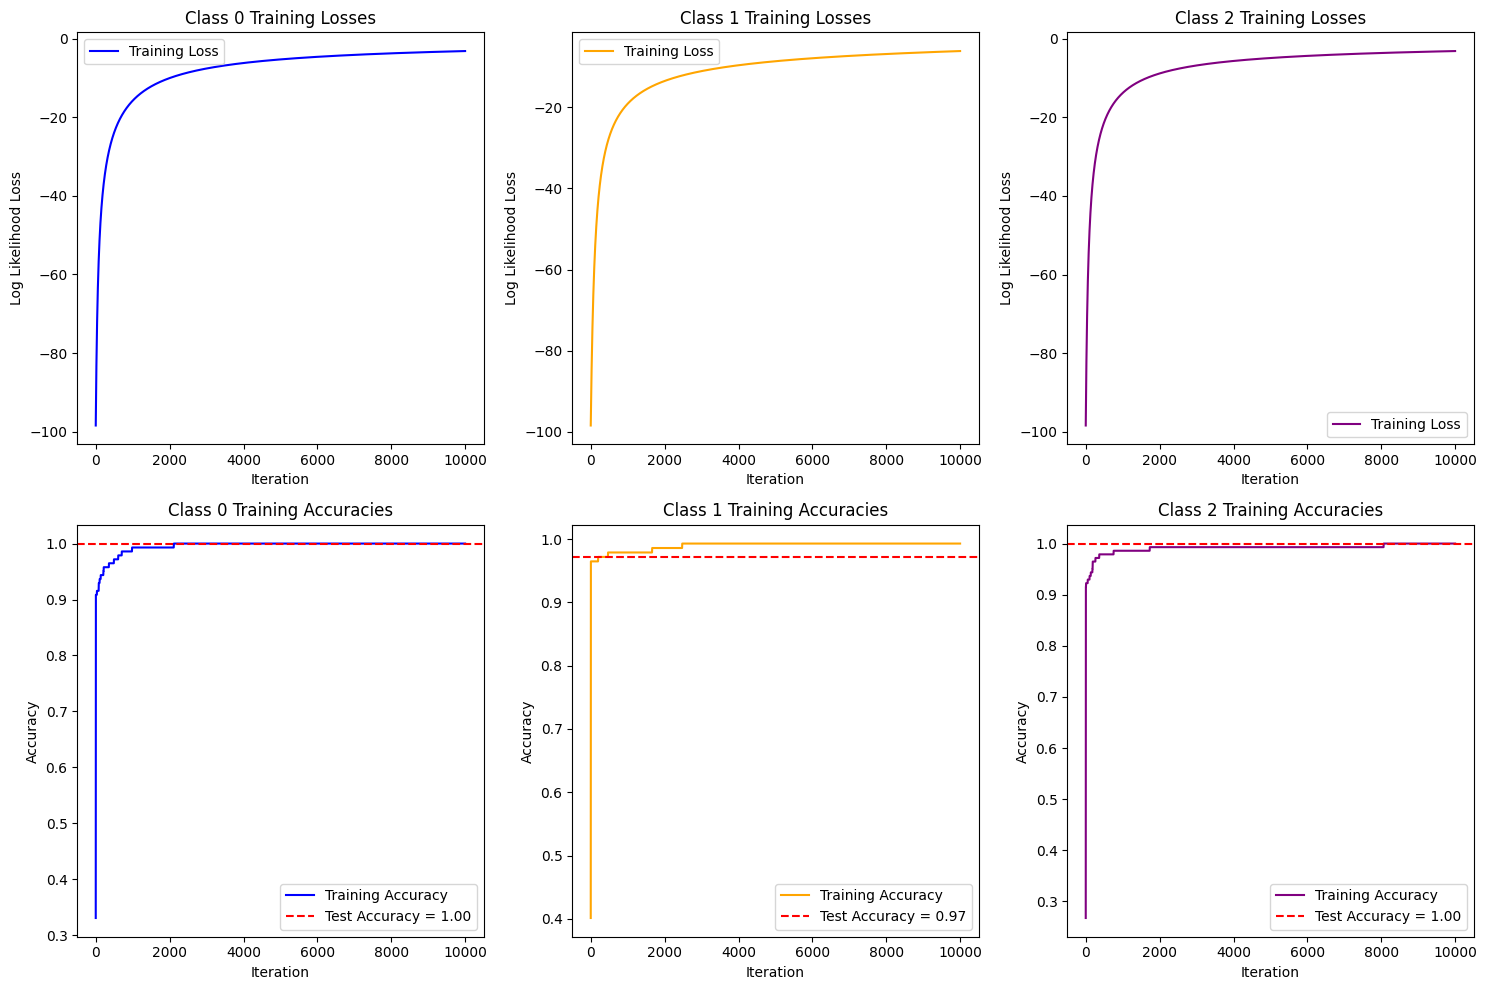

In [68]:
# Create plot figure
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot training loss for each model
axs[0, 0].plot(range(scratch_logisticRegressionModel_class0.numIterations), scratch_logisticRegressionModel_class0.trainingLosses, color='blue', label='Training Loss')
axs[0, 1].plot(range(scratch_logisticRegressionModel_class1.numIterations), scratch_logisticRegressionModel_class1.trainingLosses, color='orange', label='Training Loss')
axs[0, 2].plot(range(scratch_logisticRegressionModel_class2.numIterations), scratch_logisticRegressionModel_class2.trainingLosses, color='purple', label='Training Loss')
axs[0, 0].set_title(f"Class 0 Training Losses")
axs[0, 1].set_title(f"Class 1 Training Losses")
axs[0, 2].set_title(f"Class 2 Training Losses")
axs[0, 0].set_xlabel("Iteration")
axs[0, 1].set_xlabel("Iteration")
axs[0, 2].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Log Likelihood Loss")
axs[0, 1].set_ylabel("Log Likelihood Loss")
axs[0, 2].set_ylabel("Log Likelihood Loss")

# Plot training accuracies for each model
axs[1, 0].plot(range(scratch_logisticRegressionModel_class0.numIterations), scratch_logisticRegressionModel_class0.trainingAccuracies, color='blue', label='Training Accuracy')
axs[1, 1].plot(range(scratch_logisticRegressionModel_class1.numIterations), scratch_logisticRegressionModel_class1.trainingAccuracies, color='orange', label='Training Accuracy')
axs[1, 2].plot(range(scratch_logisticRegressionModel_class2.numIterations), scratch_logisticRegressionModel_class2.trainingAccuracies, color='purple', label='Training Accuracy')
axs[1, 0].set_title(f"Class 0 Training Accuracies")
axs[1, 1].set_title(f"Class 1 Training Accuracies")
axs[1, 2].set_title(f"Class 2 Training Accuracies")
axs[1, 0].set_xlabel("Iteration")
axs[1, 1].set_xlabel("Iteration")
axs[1, 2].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 2].set_ylabel("Accuracy")

# Add a horizontal line for each test accuracy
axs[1, 0].axhline(y=scratch_accuracy_test_class0, color='red', linestyle='--', label=f'Test Accuracy = {scratch_accuracy_test_class0:.2f}')
axs[1, 1].axhline(y=scratch_accuracy_test_class1, color='red', linestyle='--', label=f'Test Accuracy = {scratch_accuracy_test_class1:.2f}')
axs[1, 2].axhline(y=scratch_accuracy_test_class2, color='red', linestyle='--', label=f'Test Accuracy = {scratch_accuracy_test_class2:.2f}')

# Show legends
for ax in axs.flat:
	ax.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


## Part 3: Logistic Regression with Scikit Learn (No Regularization)

This section will implement logistic regression using scikit learn.

### Class Models Creations

This code block will create models using sklearn for each class.

In [69]:
# Create model for each class
sklearn_logisticRegressionModel_class0 = LogisticRegression(penalty=None, max_iter=10000)
sklearn_logisticRegressionModel_class1 = LogisticRegression(penalty=None, max_iter=10000)
sklearn_logisticRegressionModel_class2 = LogisticRegression(penalty=None, max_iter=10000)

### Model Training

This code block will train each model.

In [70]:
# Train each model
sklearn_logisticRegressionModel_class0.fit(X=train_Features_scaled, y=train_Target_encoded["class_0"].values)
sklearn_logisticRegressionModel_class1.fit(X=train_Features_scaled, y=train_Target_encoded["class_1"].values)
sklearn_logisticRegressionModel_class2.fit(X=train_Features_scaled, y=train_Target_encoded["class_2"].values)

# Get final predictions for each model
sklearn_predictions_finalTraining_class0 = sklearn_logisticRegressionModel_class0.predict(train_Features_scaled)
sklearn_predictions_finalTraining_class1 = sklearn_logisticRegressionModel_class1.predict(train_Features_scaled)
sklearn_predictions_finalTraining_class2 = sklearn_logisticRegressionModel_class2.predict(train_Features_scaled)

# Get accuracies for each model on training data
sklearn_accuracy_finalTraining_class0 = accuracy_score(train_Target_encoded["class_0"].values, sklearn_predictions_finalTraining_class0)
sklearn_accuracy_finalTraining_class1 = accuracy_score(train_Target_encoded["class_1"].values, sklearn_predictions_finalTraining_class1)
sklearn_accuracy_finalTraining_class2 = accuracy_score(train_Target_encoded["class_2"].values, sklearn_predictions_finalTraining_class2)

### Model Testing

This code block will test each model.

In [71]:
# Get predictions on test data for each model
sklearn_predictions_class0 = sklearn_logisticRegressionModel_class0.predict(test_Features_scaled)
sklearn_predictions_class1 = sklearn_logisticRegressionModel_class1.predict(test_Features_scaled)
sklearn_predictions_class2 = sklearn_logisticRegressionModel_class2.predict(test_Features_scaled)

# Compute test accuracies for each model
sklearn_accuracy_test_class0 = accuracy_score(test_Target_encoded["class_0"].values, sklearn_predictions_class0)
sklearn_accuracy_test_class1 = accuracy_score(test_Target_encoded["class_1"].values, sklearn_predictions_class1)
sklearn_accuracy_test_class2 = accuracy_score(test_Target_encoded["class_2"].values, sklearn_predictions_class2)

# Get the confusion matrix for each model
sklearn_confusionMatrix_class0 = confusion_matrix(test_Target_encoded["class_0"].values, sklearn_predictions_class0)
sklearn_confusionMatrix_class1 = confusion_matrix(test_Target_encoded["class_1"].values, sklearn_predictions_class1)
sklearn_confusionMatrix_class2 = confusion_matrix(test_Target_encoded["class_2"].values, sklearn_predictions_class2)

### Weight Extraction

This code block will extract the weights and rank each feature by absolute value of weight.

In [72]:
# Get the weights for each model
sklearn_weights_class0 = sklearn_logisticRegressionModel_class0.coef_[0]
sklearn_weights_class1 = sklearn_logisticRegressionModel_class1.coef_[0]
sklearn_weights_class2 = sklearn_logisticRegressionModel_class2.coef_[0]

# Order the features by absolute weight value for each class
sklearn_featureRanking_class0 = np.argsort(np.abs(sklearn_weights_class0))[::-1]
sklearn_featureRanking_class1 = np.argsort(np.abs(sklearn_weights_class1))[::-1]
sklearn_featureRanking_class2 = np.argsort(np.abs(sklearn_weights_class2))[::-1]

### Metric Display

This code block will provide a table of all weights indicating the top 3 features for each class, a plot of training accuracy, and a confusion matrix on the test data.

Feature Rankings Per Class
|| Class   || Top Feature                 || Second Top Feature   || Third Top Feature                     || Fourth Top Feature                    || Fifth Top Feature         || Sixth Top Feature              || Seventh Top Feature            || Eighth Top Feature        || Ninth Top Feature           || Tenth Top Feature   || Eleventh Top Feature    || Twelfth Top Feature                   || Thirteenth Top Feature         ||
| Class 0 | alcalinity_of_ash = -6.7129 | proline = 6.5546     | flavanoids = 5.6570                   | od280/od315_of_diluted_wines = 5.3221 | alcohol = 4.7514          | ash = 4.4484                   | malic_acid = 1.9431            | proanthocyanins = -1.6050 | magnesium = 1.2209          | hue = -1.1093       | total_phenols = -0.5360 | color_intensity = 0.3139              | nonflavanoid_phenols = -0.1833 |
| Class 1 | color_intensity = 0.3139    | proline = 6.5546     | ash = 4.4484                          | alcohol = 4.7514 

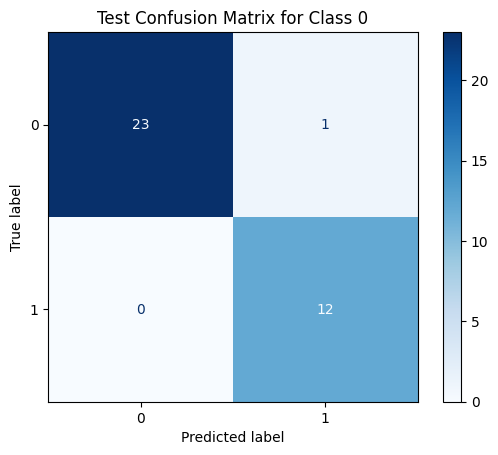

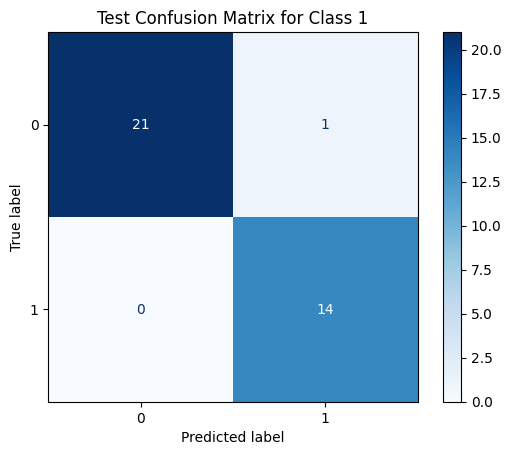

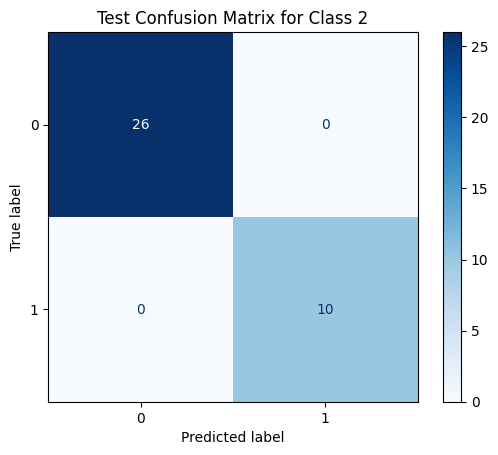

In [74]:
# Get the feature names from raw data
featureNames = df_Features.columns.tolist()

# Build a table to show the ranked features for each class
print(f"Feature Rankings Per Class")
tableHeaders_featureRankings = ["Class", "Top Feature", "Second Top Feature", "Third Top Feature", "Fourth Top Feature", "Fifth Top Feature", "Sixth Top Feature", "Seventh Top Feature", "Eighth Top Feature", "Ninth Top Feature", "Tenth Top Feature", "Eleventh Top Feature", "Twelfth Top Feature", "Thirteenth Top Feature"]
tableRows_featureRankings = []
for classIndex, rankings in enumerate([sklearn_featureRanking_class0, sklearn_featureRanking_class1, sklearn_featureRanking_class2]):
	tableRows_featureRankings.append([f"Class {classIndex}"] + [f"{featureNames[rankings[i]]} = {sklearn_weights_class0[rankings[i]]:.4f}" for i in range(13)])
print(tabulate.tabulate(tabular_data=tableRows_featureRankings, headers=tableHeaders_featureRankings, tablefmt="jira"))

# Build a table to show the final training and testing accuracies for each class
print(f"\nFinal Training and Testing Accuracies Per Class")
tableHeaders_accuracies = ["Class", "Final Training Accuracy", "Test Accuracy"]
tableRows_accuracies = [
	["Class 0", f"{sklearn_accuracy_finalTraining_class0:.4f}", f"{sklearn_accuracy_test_class0:.4f}"],
	["Class 1", f"{sklearn_accuracy_finalTraining_class1:.4f}", f"{sklearn_accuracy_test_class1:.4f}"],
	["Class 2", f"{sklearn_accuracy_finalTraining_class2:.4f}", f"{sklearn_accuracy_test_class2:.4f}"],
]
print(tabulate.tabulate(tabular_data=tableRows_accuracies, headers=tableHeaders_accuracies, tablefmt="jira"))

# Display confusion matrix for each class
sklearn_cmdisplay_class0 = ConfusionMatrixDisplay(confusion_matrix=sklearn_confusionMatrix_class0)
sklearn_cmdisplay_class0.plot(cmap='Blues')
plt.title("Test Confusion Matrix for Class 0")
plt.show()
sklearn_cmdisplay_class1 = ConfusionMatrixDisplay(confusion_matrix=sklearn_confusionMatrix_class1)
sklearn_cmdisplay_class1.plot(cmap='Blues')
plt.title("Test Confusion Matrix for Class 1")
plt.show()
sklearn_cmdisplay_class2 = ConfusionMatrixDisplay(confusion_matrix=sklearn_confusionMatrix_class2)
sklearn_cmdisplay_class2.plot(cmap='Blues')
plt.title("Test Confusion Matrix for Class 2")
plt.show()